In [1]:
import os, sys
import glob
import iris
import datetime
import numpy as np
import matplotlib.pyplot as plt
import iris.quickplot as qplt
import iris.plot as iplt
import warnings
warnings.filterwarnings("ignore")
%matplotlib tk

In [2]:
def get_file_name(date, varname):
    forecast_out_dir = '/scratch/hadpx/SEA_monitoring/processed_MJO_data/mogreps/coldsurge'
    concated_dir = os.path.join(forecast_out_dir, varname)
    file_name = os.path.join(concated_dir,
                                    f'{varname}_ColdSurge_24h_allMember_{date.strftime("%Y%m%d")}.nc')
    return file_name
    
def extract_and_collapse(cube, box):
    extracted_cube = cube.intersection(latitude=(box[2], box[3]), longitude=(box[0], box[1]))
    return extracted_cube.collapsed(('latitude', 'longitude'), iris.analysis.MEAN)

In [3]:
date = datetime.date(2024, 2, 11)
u850_file_name = get_file_name(date, 'u850')
v850_file_name = get_file_name(date, 'v850')

In [4]:
u850_cube = iris.load_cube(u850_file_name)
u850_cube = u850_cube.intersection(longitude=(90, 135))
v850_cube = iris.load_cube(v850_file_name)
v850_cube = v850_cube.intersection(longitude=(90, 135))

In [5]:
# Compute speed
speed_cube = (u850_cube ** 2 + v850_cube ** 2) ** 0.5

In [6]:
# Cold surge identification
chang_box = [107, 115, 5, 10]  # CP Chang's 2nd domain

# Hattori box for cross equatorial surges
hattori_box = [105, 115, -5, 5]

Chang_threshold = 9.0  # 10 # wind speed m/s
Hattori_threshold = -2.0  # m/s meridional wind

u850_ba = extract_and_collapse(u850_cube, chang_box)
v850_ba = extract_and_collapse(v850_cube, chang_box)
speed_ba = extract_and_collapse(speed_cube, chang_box)
v850_hattori = extract_and_collapse(v850_cube, hattori_box)

In [7]:
qplt.contourf(speed_cube[0, 1])
iplt.quiver(u850_cube[0, 1, ::5, ::5], v850_cube[0, 1, ::5, ::5], scale=300)  # Adjust scale as needed

In [8]:
mask1 = (u850_ba.data < 0.) & (v850_ba.data < 0.) & (speed_ba.data >= Chang_threshold)
mask2 = mask1 & (v850_hattori.data <= Hattori_threshold)
cs_prob = [round(p, 1) for p in 100.*np.sum(mask1, axis=0)/float(len(mask1))]
ces_prob = [round(p, 1) for p in 100.*np.sum(mask2, axis=0)/float(len(mask2))]
print(cs_prob, ces_prob)

mem = 1
plt.plot(u850_ba[mem].data, label='u')
plt.plot(v850_ba[mem].data, label='v')
plt.plot(speed_ba[mem].data, label='s')
plt.plot(v850_hattori[mem].data, label='hattori')
plt.plot(mask1[mem]*10, 'b*', label='cs')
plt.plot(mask2[mem]*10, 'o', label='ces', alpha=0.5)
plt.legend()

[100.0, 100.0, 100.0, 72.2, 94.4, 94.4, 30.6, 0.0] [100.0, 33.3, 2.8, 0.0, 33.3, 75.0, 0.0, 0.0]


In [9]:
fig, ax1 = plt.subplots()

for mem in range(36):
    if mem == 1:
        ax1.plot(u850_ba[mem].data, color='b', alpha=0.2, label='u850')
        ax1.plot(v850_ba[mem].data, color='r', alpha=0.4, label='v850')
        ax1.plot(speed_ba[mem].data, color='g', alpha=0.4, label='speed850')
        ax1.plot(v850_hattori[mem].data, color='orange', alpha=0.4, label='v850 Eq.')
    else:
        ax1.plot(u850_ba[mem].data, color='b', alpha=0.2)
        ax1.plot(v850_ba[mem].data, color='r', alpha=0.4)
        ax1.plot(speed_ba[mem].data, color='g', alpha=0.4)
        ax1.plot(v850_hattori[mem].data, color='orange', alpha=0.4)
ax1.set_xlabel('u850')
ax1.set_ylabel('v850')
ax1.axhline(0, color='grey', linestyle='--')
ax1.axhline(9, color='grey', linestyle='--')
ax1.axhline(-2, color='grey', linestyle='--')
ax1.set_xlim([0, 7])
ax1.legend()

# Create a twin Axes object sharing the same x-axis
ax2 = ax1.twinx()
ax2.bar(range(8), cs_prob, color='blue', alpha=0.2, label='CS prob')
ax2.bar(range(8), ces_prob, color='orange', alpha=0.5, label='CES prob')
# Add legends
#ax1.legend(loc='upper left')  # Legend for Variable 1
ax2.legend(loc='upper left')  # Legend for Variable 2

#plt.ylim([-15, 15])#
#plt.plot([])

In [150]:
mem=1
#plt.quiver(u850_ba[mem].data, v850_ba[mem].data)
plt.quiver(np.ma.masked_array(u850_ba[mem].data, mask=~mask2[mem]), np.ma.masked_array(v850_ba[mem].data, mask=~mask2[mem]), color='red')

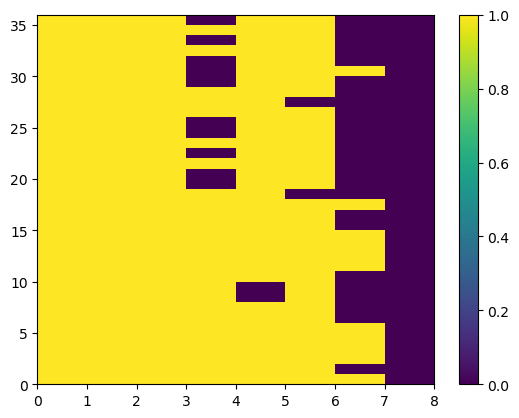

In [63]:
plt.pcolormesh(mask1)
plt.colorbar()

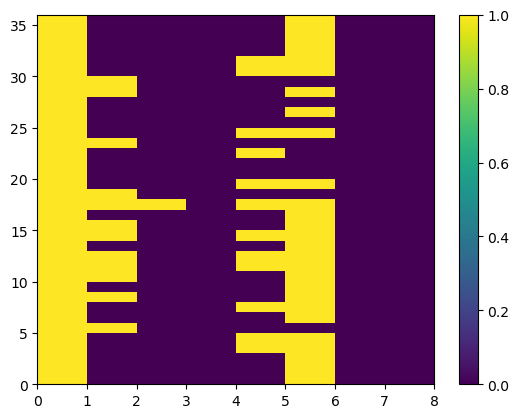

In [64]:
plt.pcolormesh(mask2)
plt.colorbar()

([100.0, 100.0, 100.0, 72.2, 94.4, 94.4, 30.6, 0.0],
 [100.0, 33.3, 2.8, 0.0, 33.3, 75.0, 0.0, 0.0])

In [75]:
round(33.333, 2)

33.33